# Comparación de algoritmos jerárquicos en databases sintéticas

En este ejemplo se trabaja con conectividad, lo que modifica los agrupamientos considerando etiquetas vecinas.
Sin considerar conectividad los algoritmos son bastante menos robustos a formaciones no globulares.

In [1]:
import time
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from itertools import cycle, islice

np.random.seed(0)

In [2]:
"""
Generate datasets.
We choose the size big enough to see the scalability of the
algorithms, but not too big to avoid too long running times
"""
n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

blobs = datasets.make_blobs(n_samples=n_samples, random_state=10)

no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 100

X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

transformation = [ [0.6, -0.6]
                 , [-0.4, 0.8]
                 ]

X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# Blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

In [3]:
# Set up cluster parameters
plot_num = 1

default_base = { 'n_neighbors': 10
               , 'n_clusters': 3
               }

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'n_neighbors': 2}),
    (aniso, {'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})
]

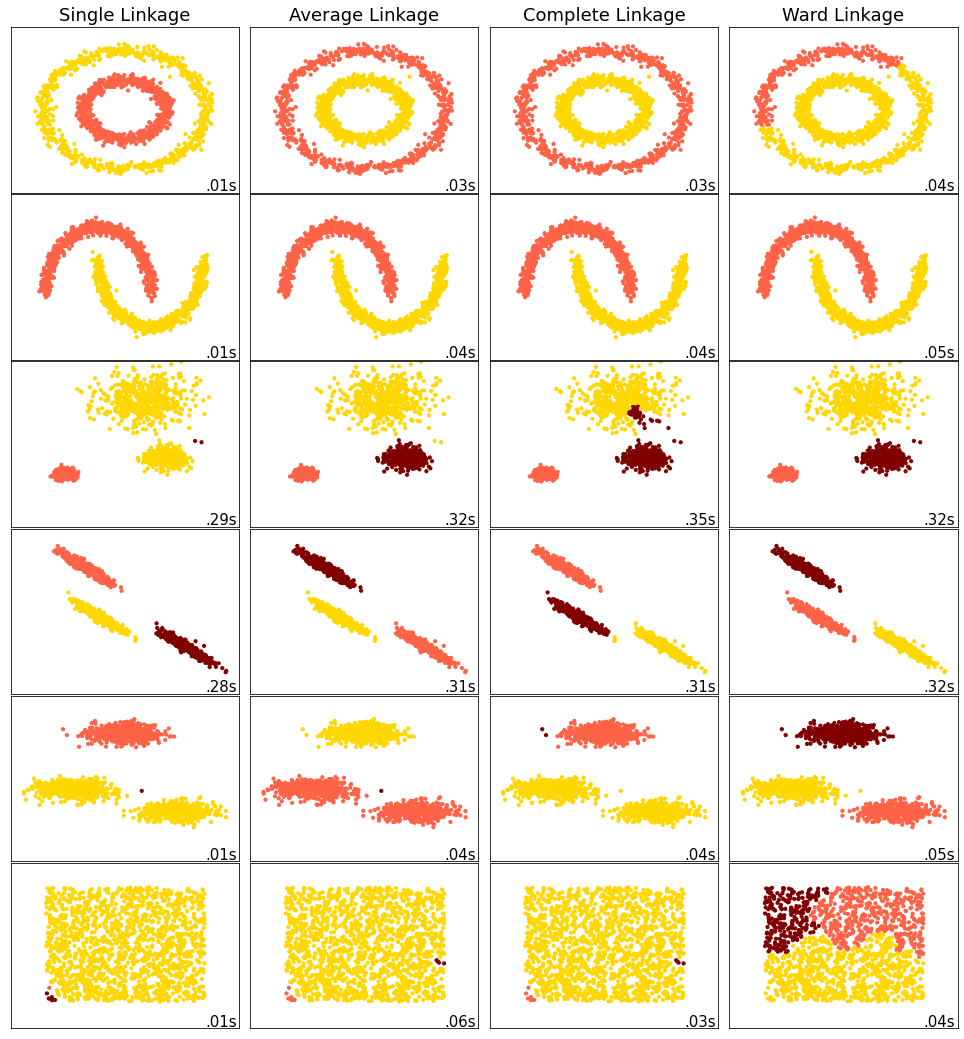

In [4]:
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

# Run the clustering and plot
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # Update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # Normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # Connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    # Make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'],
        linkage='single',
        connectivity=connectivity
    )

    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'],
        linkage='average',
        connectivity=connectivity
    )

    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'],
        linkage='complete',
        connectivity=connectivity
    )

    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'],
        linkage='ward',
        connectivity=connectivity
    )

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # Fit the clustering
        algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(
            cycle(
                ['gold', 'tomato', 'maroon', 'lightsalmon', 'orangered', 'firebrick', 'rosybrown', 'mistyrose', 'peachpuff']
            ),
            int(max(y_pred) + 1)
        )))

        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99,
                 .01,
                 ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes,
                 size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()